# Integration Method by Matt (Example using `IndShockConsumer`)

Constructing End of Period (Marginal) Value Function using Transitionmatrices instead of Expectations.
This notebook shows the necessary steps to construct the function. For simplicity, we will only focus on transitory shock without unemployment probability nor permanent shocks.

Idea by Matt White
Code by Adrian Monninger

In [1]:
from HARK.econforgeinterp import LinearFast
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
import numpy as np

from HARK.distribution import (
    expected,
)

import matplotlib.pyplot as plt

from HARK.utilities import make_grid_exp_mult
import scipy as sp

c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
T_cycles = 5
PermShk = 0.00
TranShk = 0.2
ShockCount = 21
UnempPrb = 0.0
CRRA = 2
Rfree = 1.04**.25
DiscFac = 0.975
PermGroFac = 1.0
LivPrb = 0.99375
DiscFacEff = DiscFac * LivPrb

Dict={
    "CRRA": CRRA,
    "Rfree": [Rfree] * T_cycles,                   # Interest factor on assets
    "DiscFac": DiscFac,                     # Intertemporal discount factor
    "LivPrb" : [LivPrb] * T_cycles, #[0.999], #[.99375],                  # Survival probability
    "PermGroFac" : [PermGroFac] * T_cycles,                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" :   [PermShk] * T_cycles, #[.06],                 # Standard deviation of log permanent shocks to income
    "PermShkCount" : ShockCount,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [TranShk] * T_cycles, #[.2],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : ShockCount,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : [UnempPrb] * T_cycles,                     # Probability of unemployment while working
    "IncUnemp" :  [0.0] * T_cycles,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : [0.0] * T_cycles,                # Probability of "unemployment" while retired
    "IncUnempRet" : [0.0] * T_cycles,                   # "Unemployment" benefits when retired
    "T_cycle" : T_cycles,                         # Number of periods in the cycle for this agent type

}

In [3]:
IndShock = IndShockConsumerType(**Dict)
IndShock.update()
IndShock.solve()

new period solve(self)
new period solve(self)
new period solve(self)
new period solve(self)
new period solve(self)


In [4]:
t = 0
tNext = 1

In [5]:
### Get Last Period Marginal Value Function and grids
# cFuncNext = IndShock.solution[1].cFunc
# vPfuncNext = MargValueFuncCRRA(cFuncNext, CRRA)
vPfuncNext = IndShock.solution[tNext].vPfunc
aXtraGrid = IndShock.aXtraGrid

### Shocks
IncShkDstn = IndShock.IncShkDstn[t]
ShkPrbsNext = IncShkDstn.pmv
PermShkValsNext = IncShkDstn.atoms[0]
TranShkValsNext = IncShkDstn.atoms[1]
PermShkMinNext = np.min(PermShkValsNext)
TranShkMinNext = np.min(TranShkValsNext)

# Borrowing Constraint
BoroCnstNat = (
    (IndShock.solution[tNext].mNrmMin - TranShkMinNext)
    * (IndShock.PermGroFac[t] * PermShkMinNext)
    / IndShock.Rfree[t] )

aNrmNow = np.asarray(aXtraGrid) + BoroCnstNat

In [6]:
def m_nrm_next(PermGroFac, shocks, a_nrm, Rfree):
    """
    Computes normalized market resources of the next period
    from income shocks and current normalized market resources.

    Parameters
    ----------
    shocks: [float]
        Permanent and transitory income shock levels.
    a_nrm: float
        Normalized market assets this period

    Returns
    -------
    float
        normalized market resources in the next period
    """
    return Rfree / (PermGroFac * shocks["PermShk"]) * a_nrm + shocks["TranShk"]

In [7]:
### End-of-period Marginal Value Function (Traditional Way)

def vp_next(shocks, a_nrm, Rfree):
    return shocks["PermShk"] ** (-CRRA) * vPfuncNext(
        m_nrm_next(PermGroFac, shocks, a_nrm, Rfree)
    )

EndOfPrdvP = (
    DiscFacEff
    * Rfree
    * PermGroFac ** (-CRRA)
    * expected(vp_next, IncShkDstn, args=(aNrmNow, Rfree))
        )

(0.0, 2.0)

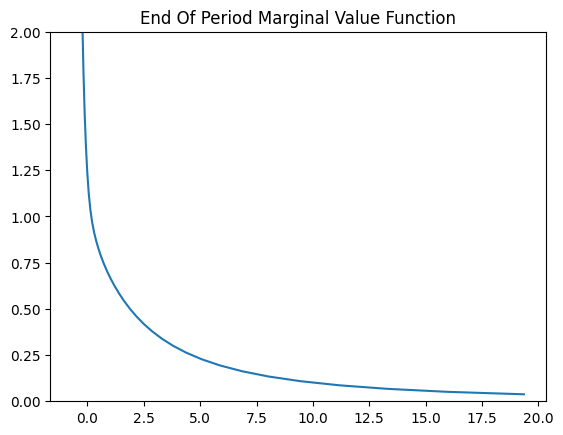

In [8]:
plt.plot(aNrmNow, EndOfPrdvP)
plt.title('End Of Period Marginal Value Function')
plt.ylim([0.0, 2.0])

### Alternative Start

In [9]:
### Step 1: In a pre-solution step, specify fairly dense grids of m and b, denser than the grid of a.
mGrid = make_grid_exp_mult(0.0, 50, 300)
bGrid = make_grid_exp_mult(0.0, 50, 300)

### Let ist start from minimum of aNrm
mGrid = mGrid - aNrmNow[0]
bGrid = bGrid - aNrmNow[0]


(0.0, 2.0)

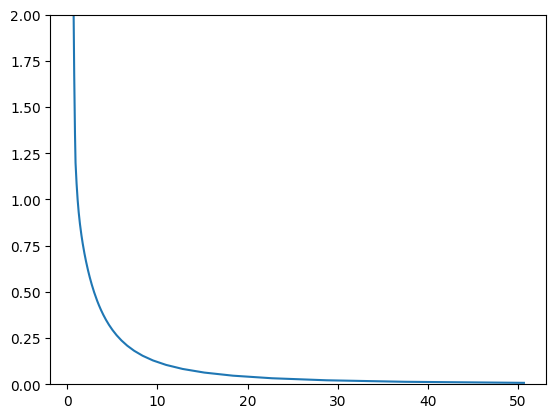

In [10]:
plt.plot(mGrid, vPfuncNext(mGrid))
plt.ylim([0.0, 2.0])

In [11]:
### Step 2: In that pre-solution step, for each $F_{\theta, t}$ (i.e. just once if this is an ifinite horizon problem), 
###         calculate $f_{\theta, t}(m - b) on the cross product of the b-grid and m-grid. 
###         Put them in a matrix that has b values by row and m values by column.
###         Still in the pre-solution step, for each b-row in the matrix, take the row-wise sum and
###         divide the row by it. This represents a Markov transition matrix from the exogenous
###         b-grid to the exogenous m-grid.

def updateBM_TranMatrix(TranShkStd, bGrid, mGrid):
    """
    Calculates the Probabillity of a transioty shock for the b times m matrix
    """
    # probGrid = np.zeros((len(self.bNrmGrid_income), len(self.mNrmGrid_income)))  # b x m
    # ### getting the probability for each transitory shock with the size b - m (remember m = b * transitory shock)

    ### Integration 1: No unemployment probability
    s = TranShkStd
    mu = -0.5 * s**2
    lognorm_dist =  sp.stats.lognorm(s, scale=np.exp(mu))

    ### Create matrix
    # Construct meshgrid of bNrmGrid_income and mNrmGrid_income
    b, m = np.meshgrid(bGrid, mGrid, indexing='ij')

    # Calculate differences between corresponding elements
    probGrid = lognorm_dist.pdf(m - b)

    for i_b in range(len(bGrid)):
        probGrid[i_b] = probGrid[i_b]/(np.max([np.sum(probGrid[i_b]), 0.000001]))

    return probGrid


In [12]:
probGrid = updateBM_TranMatrix(TranShk, bGrid, mGrid)

In [13]:
probGrid

array([[0.00000000e+000, 0.00000000e+000, 4.13785401e-280, ...,
        1.68203581e-064, 6.84678105e-075, 1.54372978e-087],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.68501768e-064, 6.85758429e-075, 1.54588270e-087],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.68802626e-064, 6.86848198e-075, 1.54805399e-087],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 2.22410422e-021, 3.84397937e-048],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 3.98381835e-032],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

In [14]:
np.sum(probGrid[0])

1.0000000000000002

In [15]:
### Step 3: To compute expectations during backwards solution, evaluate vt(mt) on the dense m-grid. Put
### these (marginal) values into a matrix that has one column.

EndOfPrdvP_Interm_array = vPfuncNext(mGrid)
large_number = 1e12
EndOfPrdvP_Interm_array = np.where(EndOfPrdvP_Interm_array == np.inf, large_number, EndOfPrdvP_Interm_array)

(0.0, 2.0)

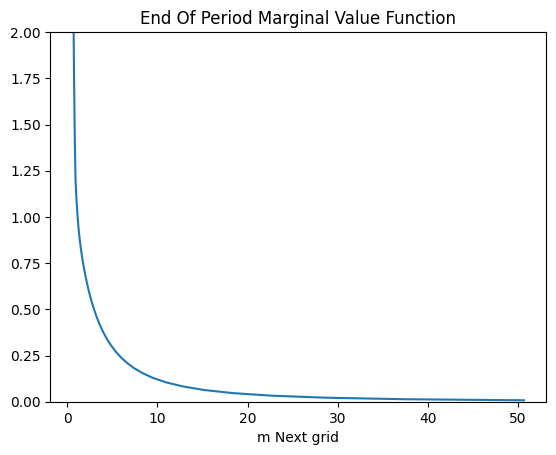

In [16]:
plt.plot(mGrid, EndOfPrdvP_Interm_array)
plt.title('End Of Period Marginal Value Function')
plt.xlabel('m Next grid')
plt.ylim([0.0, 2.0])

In [17]:
### Step 4: Pre-multiply the Markov matrix by the matrix you just constructed. The resulting
###         matrix of intermediate expected values will have b row-wise.

EndOfPrdvP_Interm_array = np.reshape(EndOfPrdvP_Interm_array, (1 ,len(EndOfPrdvP_Interm_array)))
EndOfPrdvP_Interm_array = EndOfPrdvP_Interm_array @ probGrid
EndOfPrdvP_Interm = LinearFast(EndOfPrdvP_Interm_array[0], [bGrid])

(0.0, 2.0)

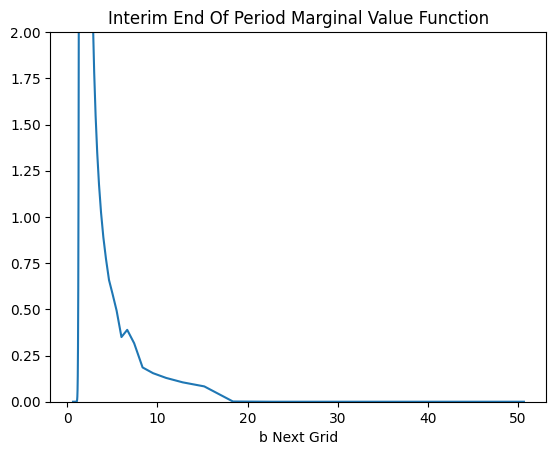

In [18]:
plt.plot(bGrid, EndOfPrdvP_Interm_array[0])
plt.title('Interim End Of Period Marginal Value Function')
plt.xlabel('b Next Grid')
plt.ylim([0.0, 2.0])

In [19]:
### Step 5: Using the pre-specified exogenous grid of a, compute expected end-of-period
###         (marginal) value using the typical discretized approximation to the permanent shock
###         distribution. For any (a) end-of-period state, there is a finite set of future (b)
###         points that can be reached under the discretization.

In [20]:
def b_nrm_next(PermGroFac, shocks, a_nrm, Rfree):
    """
    Computes normalized bank balances of the next period
    from income shocks and current normalized market resources.

    Parameters
    ----------
    shocks: [float]
        Permanent and transitory income shock levels.
    a_nrm: float
        Normalized market assets this period

    Returns
    -------
    float
        normalized market resources in the next period
    """
    return Rfree / (PermGroFac * shocks["PermShk"]) * a_nrm

In [21]:
def vp_next_Integration(shocks, a_nrm, Rfree):
    return shocks["PermShk"] ** (-CRRA) * EndOfPrdvP_Interm(
        b_nrm_next(PermGroFac, shocks, a_nrm, Rfree)
    )

In [22]:
EndOfPrdvP_Integration = (
    DiscFacEff
    * Rfree
    * PermGroFac ** (-CRRA)
    * expected(vp_next_Integration, IncShkDstn, args=(aNrmNow, Rfree))
        )

c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\interpolation\splines\eval_splines.py:232: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\interpolation\splines\eval_splines.py", line 116, in __eval_spline
    kk = (order).literal_value

  return _eval_linear(*args)


(0.0, 2.0)

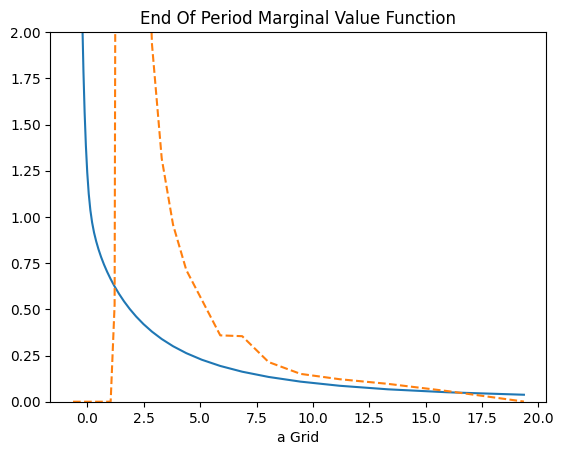

In [23]:
plt.plot(aNrmNow, EndOfPrdvP)
plt.plot(aNrmNow, EndOfPrdvP_Integration, '--')
plt.title('End Of Period Marginal Value Function')
plt.xlabel('a Grid')
plt.ylim([0.0, 2.0])